# Heart Attack Prediction Model


## Dataset preparation and summary

### Dataset information

-  Age : Age of the patient
-  Sex : Sex of the patient
-  exng: exercise induced angina (1 = yes; 0 = no)
-  caa: number of major vessels (0-3)
-  cp : Chest Pain type chest pain type
    -  Value 1: typical angina
    -  Value 2: atypical angina
    -  Value 3: non-anginal pain
    -  Value 0: asymptomatic
-  trtbps : resting blood pressure (in mm Hg)
-  chol : cholestoral in mg/dl fetched via BMI sensor
-  fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
-  restecg : resting electrocardiographic results
    -  Value 0: normal
    -  Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    -  Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
-  thalachh : maximum heart rate achieved
-  oldpeak : ST depression induced by exercise relative to rest
-  slp  : the slope of the peak exercise ST segment 
    -  Value 0: downsloping
    -  Value 1: flat
    -  Value 2: downsloping
-  thall : 
    -  Value 1: fixed defect 
    -  Value 2: normal
    -  Value 3: reversible defect
-  output : 0= less chance of heart attack 1= more chance of heart attack

### Packages

In [1]:
import pandas as pd 
import os 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import plotnine
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler 
from yellowbrick.classifier import ConfusionMatrix

# Ignore future warnings from pandas and other packages
import warnings
warnings.simplefilter(action='ignore')

### Dataset exploration

In [2]:
heart_df = pd.read_csv(".\data\heart.csv")
heart_df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


This dataset has {{heart_df.shape[0]}} observations and {{heart_df.shape[1]}} variables. 

In [3]:
# Checking for any rows with NA values
heart_df.isna().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [4]:
# Viewing the data types for each columns 
heart_df.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object

The data consists entirely of floats or integers which is not an issue for when it comes to exploratory data analysis, cleaning and modelling. No further processing is needed at this stage

In [5]:
# Summary statistics on the whole dataset to get a quick overview of the data. 
heart_df.groupby(['output']).describe()

age                                                       sex  \
        count       mean       std   min   25%   50%   75%   max  count   
output                                                                    
0       138.0  56.601449  7.962082  35.0  52.0  58.0  62.0  77.0  138.0   
1       165.0  52.496970  9.550651  29.0  44.0  52.0  59.0  76.0  165.0   

                  ...  caa       thall                                     \
            mean  ...  75%  max  count      mean       std  min  25%  50%   
output            ...                                                       
0       0.826087  ...  2.0  4.0  138.0  2.543478  0.684762  0.0  2.0  3.0   
1       0.563636  ...  0.0  4.0  165.0  2.121212  0.465752  0.0  2.0  2.0   

                  
        75%  max  
output            
0       3.0  3.0  
1       2.0  3.0  

[2 rows x 104 columns]

Initially while looking at the data at a very high level we can draw some very simple conclusions. 
It appears from this set of data the average male aged around 55 seem to experience a higher chance of suffering from a heart attack. Whilst this is a very simplistic view of the dataset I will be exploring this further with the use of some classifier models to predict whether a patient will have a higher chance of having a heart attack.

There are a wide variety of feature variables in the data which will be used to predict the outcome or the target variable. 
Whilst there are a number of major factors contributing to a heart attack my initial assumptions are that the main feature variables that will be heavily reliant on predicting the outcome will be the following (in no particular order of importance):  
-  chol
-  trtbps
-  oldpeak 

chol represents the cholesteral level in the patient. 

> When you have too much “bad” cholesterol in your body, it can start to pose a problem. It contributes to fatty deposits in the arteries called plaque, which can cause heart disease. 
When that plaque builds up, it makes it harder for blood to flow, and these deposits can eventually break and form a clot that leads to a heart attack.[<sup>1</sup>](#fn1)

However there are some alternative sources which contradict a common understanding that cholesterol leads to heart attacks, this article suggests that in a peer reviewed journal written in 2013 that looking at just cholesterol is not enough to determine a heart attack eventhood.[<sup>2</sup>](#fn2)

As I suggested previously there are a number of variables that combine and contribute to a likelyhood of a heart attack happening which brings me onto the next variable I predict will also be an important variable in the model. 

trtbps is the resting blood pressure in the patient. 

>In most cases, damage done from high blood pressure (HBP or hypertension) occurs over time. Left undetected or uncontrolled, high blood pressure can lead to:  
>Heart attack — High blood pressure damages arteries that can become blocked and prevent blood flow to the heart muscle.[<sup>3</sup>](#fn3)


The important thing to note here is that widely known and described in the article - high blood pressure can contribute to heart attacks but usually over a period of time rather than a sudden change in blood pressure.  


The next variable I think will be one main determining factor is caa which represents the number of the major vessels that are blocked by atherosclerosis. 

>Coronary heart disease (CHD) is the leading cause of heart attacks. CHD is a condition in which the coronary arteries (the major blood vessels that supply the heart with blood) become clogged with deposits of cholesterol. These deposits are called plaques.
>Before a heart attack, one of the plaques ruptures (bursts), causing a blood clot to form at the site of the rupture. The clot may block the supply of blood to the heart, triggering a heart attack.[<sup>4</sup>](#fn4)


#### Correlation Matrix and Plot

In [6]:
# Correlation matrix 

## Keeping only continuos variables 
continuous_cols = ["age","trtbps","chol","thalachh","oldpeak"]
c_matrix = heart_df[continuous_cols].corr()
c_matrix

,age,trtbps,chol,thalachh,oldpeak
age,1.000000,0.279351,0.213678,-0.398522,0.210013
trtbps,0.279351,1.000000,0.123174,-0.046698,0.193216
chol,0.213678,0.123174,1.000000,-0.009940,0.053952
thalachh,-0.398522,-0.046698,-0.009940,1.000000,-0.344187
oldpeak,0.210013,0.193216,0.053952,-0.344187,1.000000


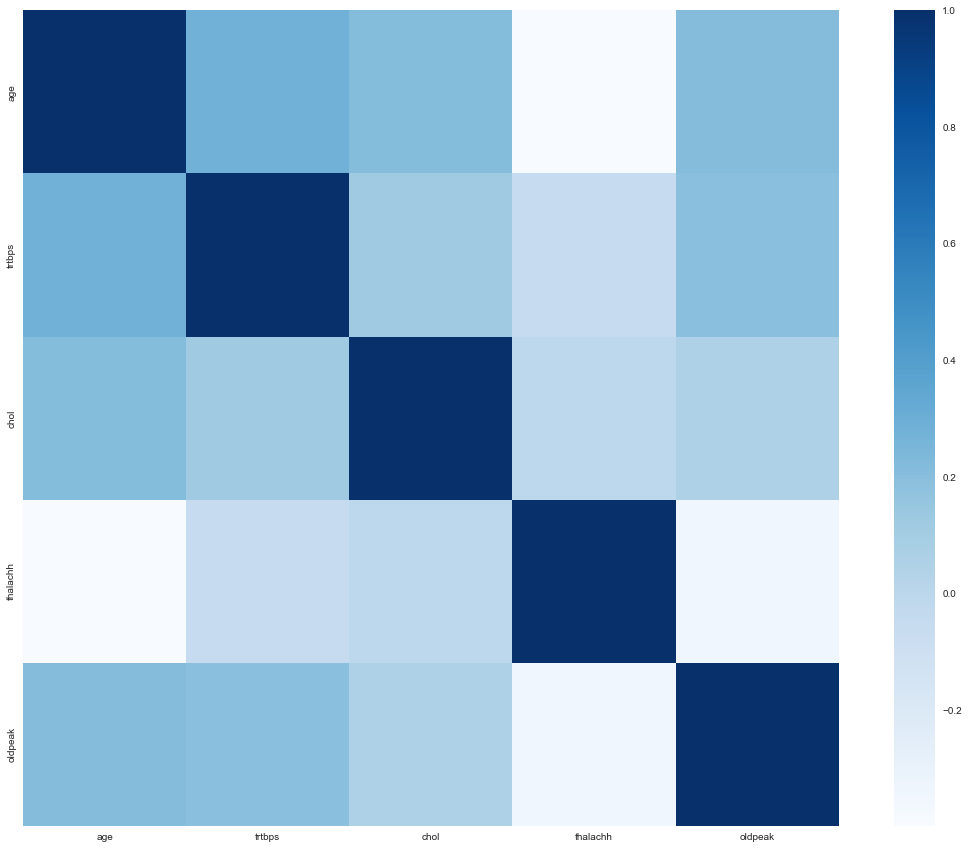

In [7]:
# Visualising the correlation matrix using a heatmap

fig, ax = plt.subplots(figsize = (20,15))
sns.heatmap(c_matrix, square = True, cmap = 'Blues');

From the correlation matrix above looking at the output column the darker blue squares indicate where we might see a positive correlation between those variables and the output (chance of a heart attack). So from this graphic its easy to pick out age, trtbps, oldpeak and chol as the variables which indicate the highest positive correlation with the output.  

This supports the initial predictions I made earlier of chol, trtbps and oldpeak which I predicted would contribute the most towards the outcome, the matrix also shows that age is one variable is quite correlated with many of the other variables. However it should be noted this correlation matrix is only showing relationships between variables rather than the ultimate outcome. It is therefore highly likely that these variables contribute together towards the heart attack outcome. 

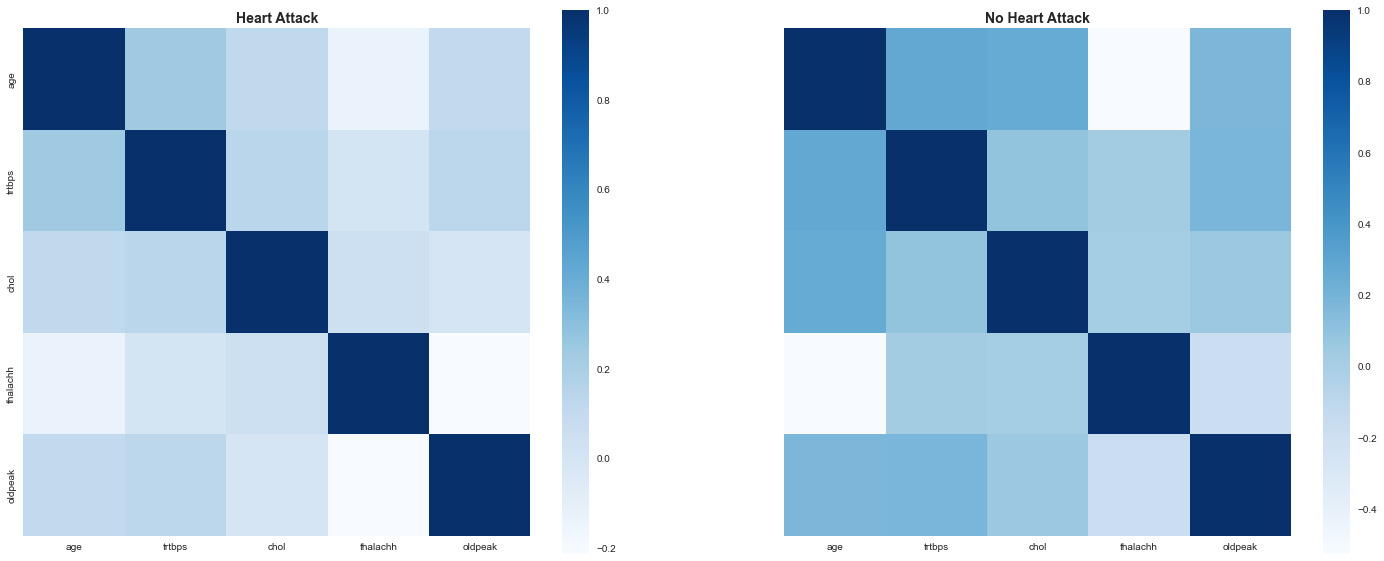

In [8]:

# Setting chart setting variables to be used throughout all charts
font = 'arial'
font_weight = 'bold'
ax_fontsize = '14'
background_colour = "#94D2BD"
colour_palette = ["#08acec","#005F73","#0A9396","#E9D8A6","#EE9B00"]

# Splitting into two dataframes based on the outcome
heart_outcome, heart_nooutcome = [x for _, x in heart_df[continuous_cols].groupby(heart_df['output'])]

# Plotting two correlation matrix for each dataframe to compare.
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharey = True, figsize = (25, 10))
sns.heatmap(heart_outcome.corr(), square = True, cmap = 'Blues', ax = ax1)
sns.heatmap(heart_nooutcome.corr(), square = True, cmap = 'Blues', ax = ax2)

ax1.set_title("Heart Attack", font = font, fontsize = ax_fontsize, fontweight = font_weight)
ax2.set_title("No Heart Attack", font = font, fontsize = ax_fontsize, fontweight = font_weight);

When we plot the correlation matrix after splitting the dataset by the outcome we can see with the Heart Attack matrix that there is not one clear stand out relationship between any variables in individuals who experienced a heart attack. This further reinforces the point made previously that it is highly likely that a combination of factors lead to a heart attack.

#### Box Plot

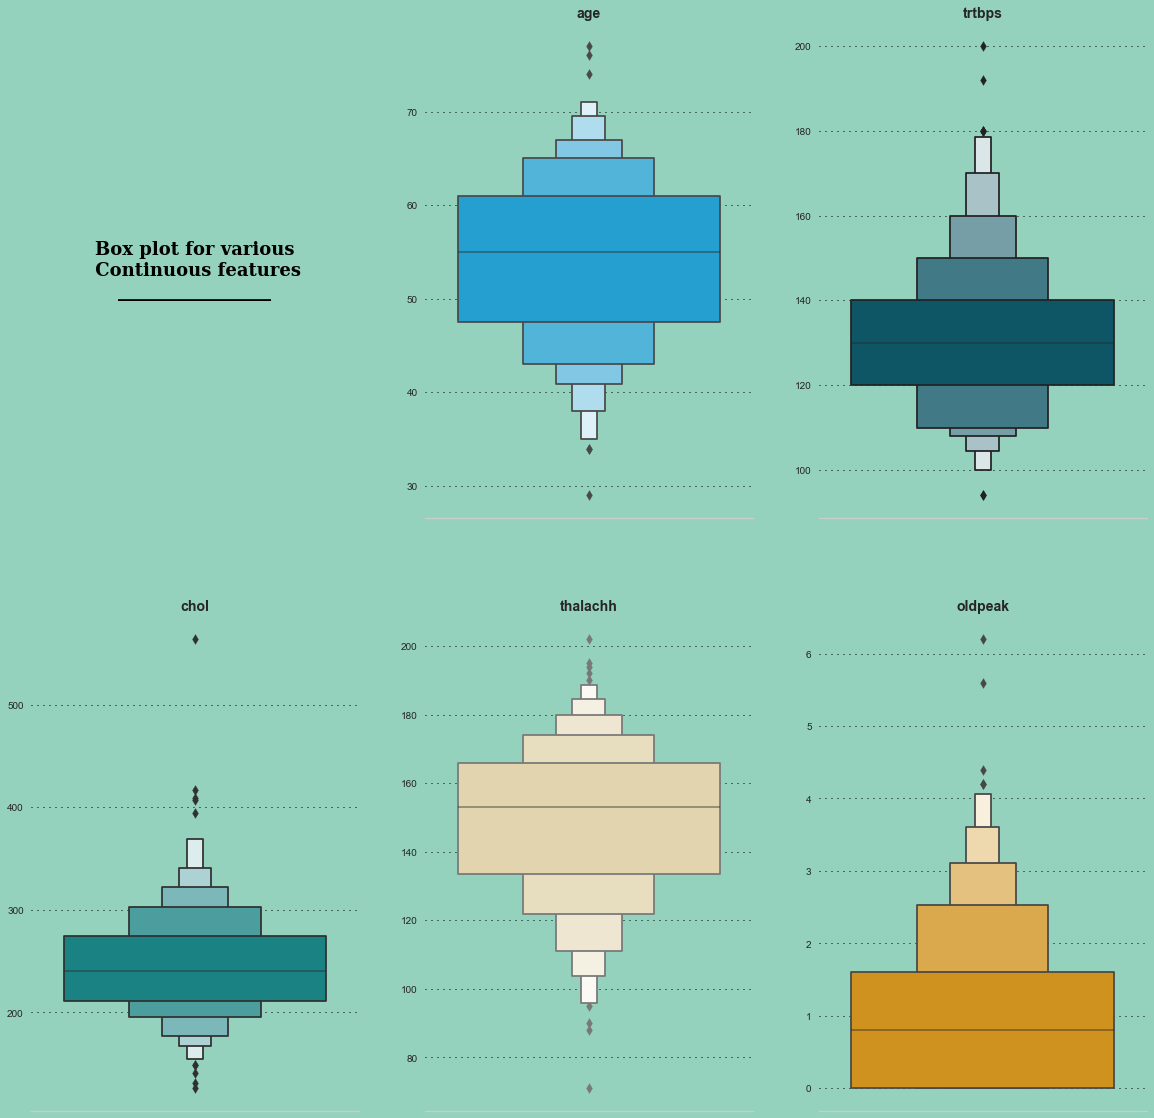

In [9]:
##replicating plots using loop 

# retreiving only the continuous cols 

continuous_cols = ['age','trtbps','chol','thalachh','oldpeak']

# Selecting only categorical columns from original dataframe
continuous_df = heart_df[continuous_cols]

# Inserting empty column to enable the first plot to display title in first axes
continuous_df.insert(0,'', 'np.nan')

n = len(continuous_cols)

# number of rows, based on cols
# Defines the layout of the plot so in this case dynamically setting to 5 rows and fixed 2 columns
rows = (int((n+1)/3))

# Instantiating plot and background colour
fig = plt.figure(figsize = (20, 20))
fig.patch.set_facecolor(background_colour)

# Loop through each column the dataframe and create a countplot
for i, column in enumerate(continuous_df):
    
    # Earlier inserted first column empty for title 
    # Apply title attribute in first axes
    if i == 0:
        ax = fig.add_subplot(rows , 3, i + 1)
        ax.set_facecolor(background_colour) 
        ax.text(0.5, 0.5,
         'Box plot for various\n Continuous features\n_________________',
         horizontalalignment = 'center',
         verticalalignment = 'center',
         fontsize = 18, fontweight = font_weight,
         fontfamily = 'serif',
         color = "#000000")
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(left = False, bottom = False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(False)
        
    else:
        #for all other axes do a countplot applying same formatting to each axes
        ax = fig.add_subplot(rows , 3, i + 1)
        sns.boxenplot(ax = ax, data = continuous_df, y = column, palette = [colour_palette[i - 1]])
        ax.set_title(column, fontsize = ax_fontsize, fontweight = font_weight, fontfamily = font)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.grid(color = "#000000", linestyle = ":", axis = 'y', zorder = 0, dashes = (1,5))
        ax.set_facecolor(background_colour)
        for s in ["top","right","left"]:
            ax.spines[s].set_visible(False)
    


#### Count Plot

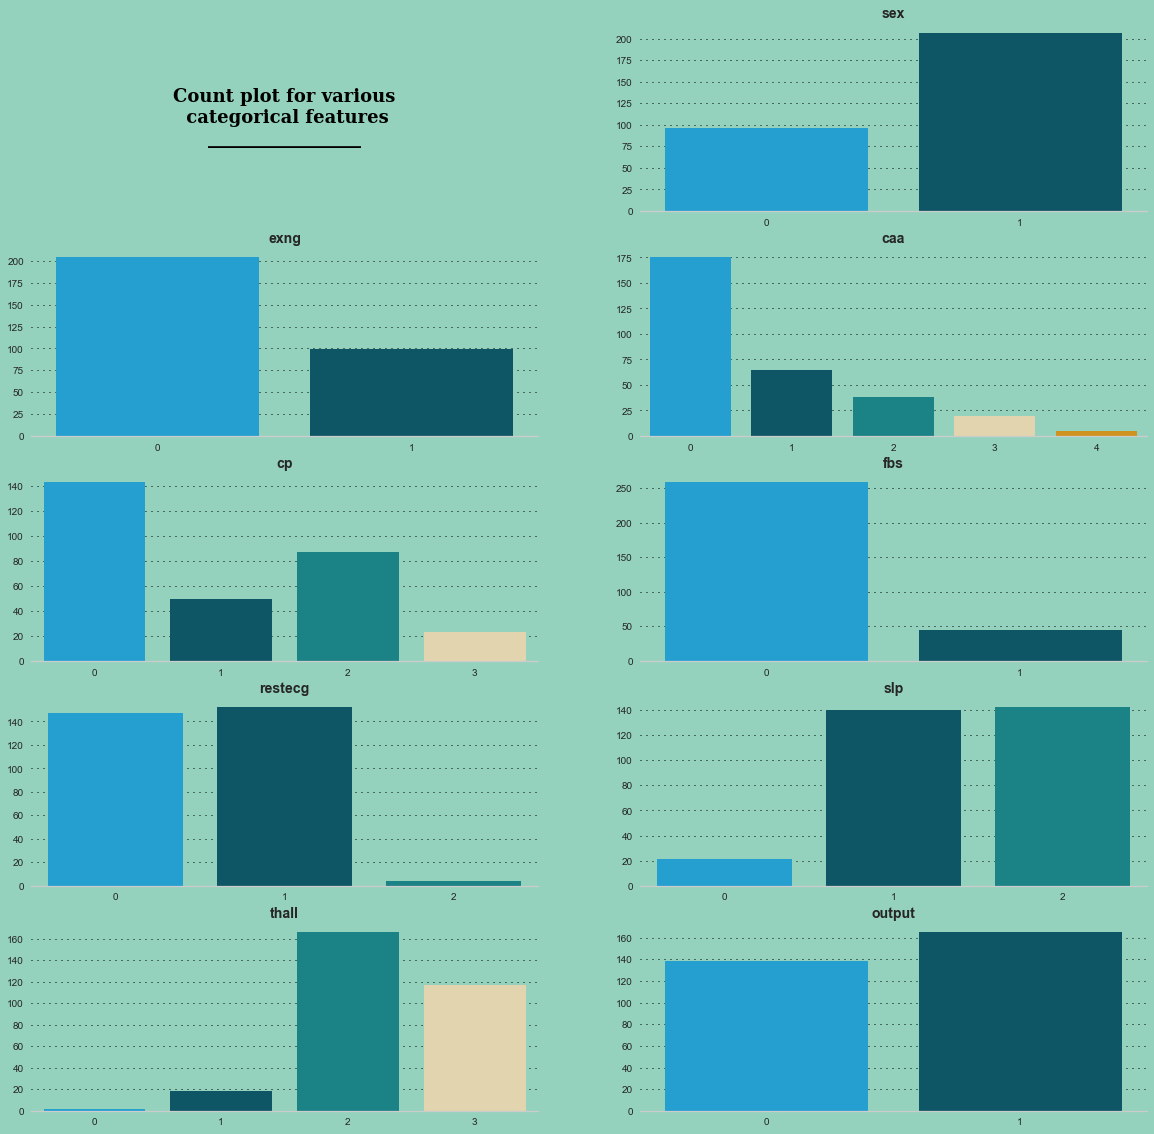

In [10]:
##replicating plots using loop 

# retreiving only the caategorical cols 

categorical_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall', 'output']

# Selecting only categorical columns from original dataframe
categorical_df = heart_df[categorical_cols]

# Inserting empty column to enable the first plot to display title in first axes
categorical_df.insert(0,'', 'np.nan')

n = len(categorical_cols)

# number of rows, based on cols
# Defines the layout of the plot so in this case dynamically setting to 5 rows and fixed 2 columns
rows = (int((n+1)/2))

# Instantiating plot and background colour
fig = plt.figure(figsize = (20, 20))
fig.patch.set_facecolor(background_colour)

# Loop through each column the dataframe and create a countplot
for i, column in enumerate(categorical_df):
    
    # Earlier inserted first column empty for title 
    # Apply title attribute in first axes
    if i == 0:
        ax = fig.add_subplot(rows , 2, i + 1)
        ax.set_facecolor(background_colour) 
        ax.text(0.5, 0.5,
         'Count plot for various\n categorical features\n_________________',
         horizontalalignment = 'center',
         verticalalignment = 'center',
         fontsize = 18, fontweight = font_weight,
         fontfamily = 'serif',
         color = "#000000")
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(left = False, bottom = False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(False)
        
    else:
        #for all other axes do a countplot applying same formatting to each axes
        ax = fig.add_subplot(rows , 2, i + 1)
        sns.countplot(ax = ax, data = categorical_df, x = column, palette = colour_palette)
        ax.set_title(column, fontsize = ax_fontsize, fontweight = font_weight, fontfamily = font)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.grid(color = "#000000", linestyle = ":", axis = 'y', zorder = 0, dashes = (1,5))
        ax.set_facecolor(background_colour)
        for s in ["top","right","left"]:
            ax.spines[s].set_visible(False)
    


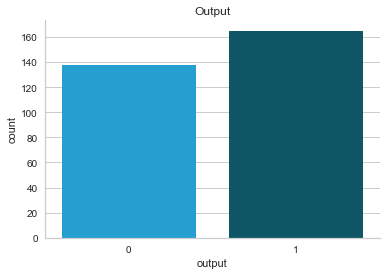

In [11]:
sns.countplot(data=heart_df, x = 'output',palette = colour_palette).set_title("Output")
sns.set_style('white')
sns.despine(top=True, right=True)

The count plot above of the output is to illustrate the balance of the class `output`. It is fairly even and not overly imbalanced.  

However in the count plot above we can see an imbalance between the `sex` and `age` with consideraly more males than females represented in the data with a large majority of ages being around the mid 50s. This can potentially cause problems with the model being bias towards new data with those attributes.

#### Pair Plot

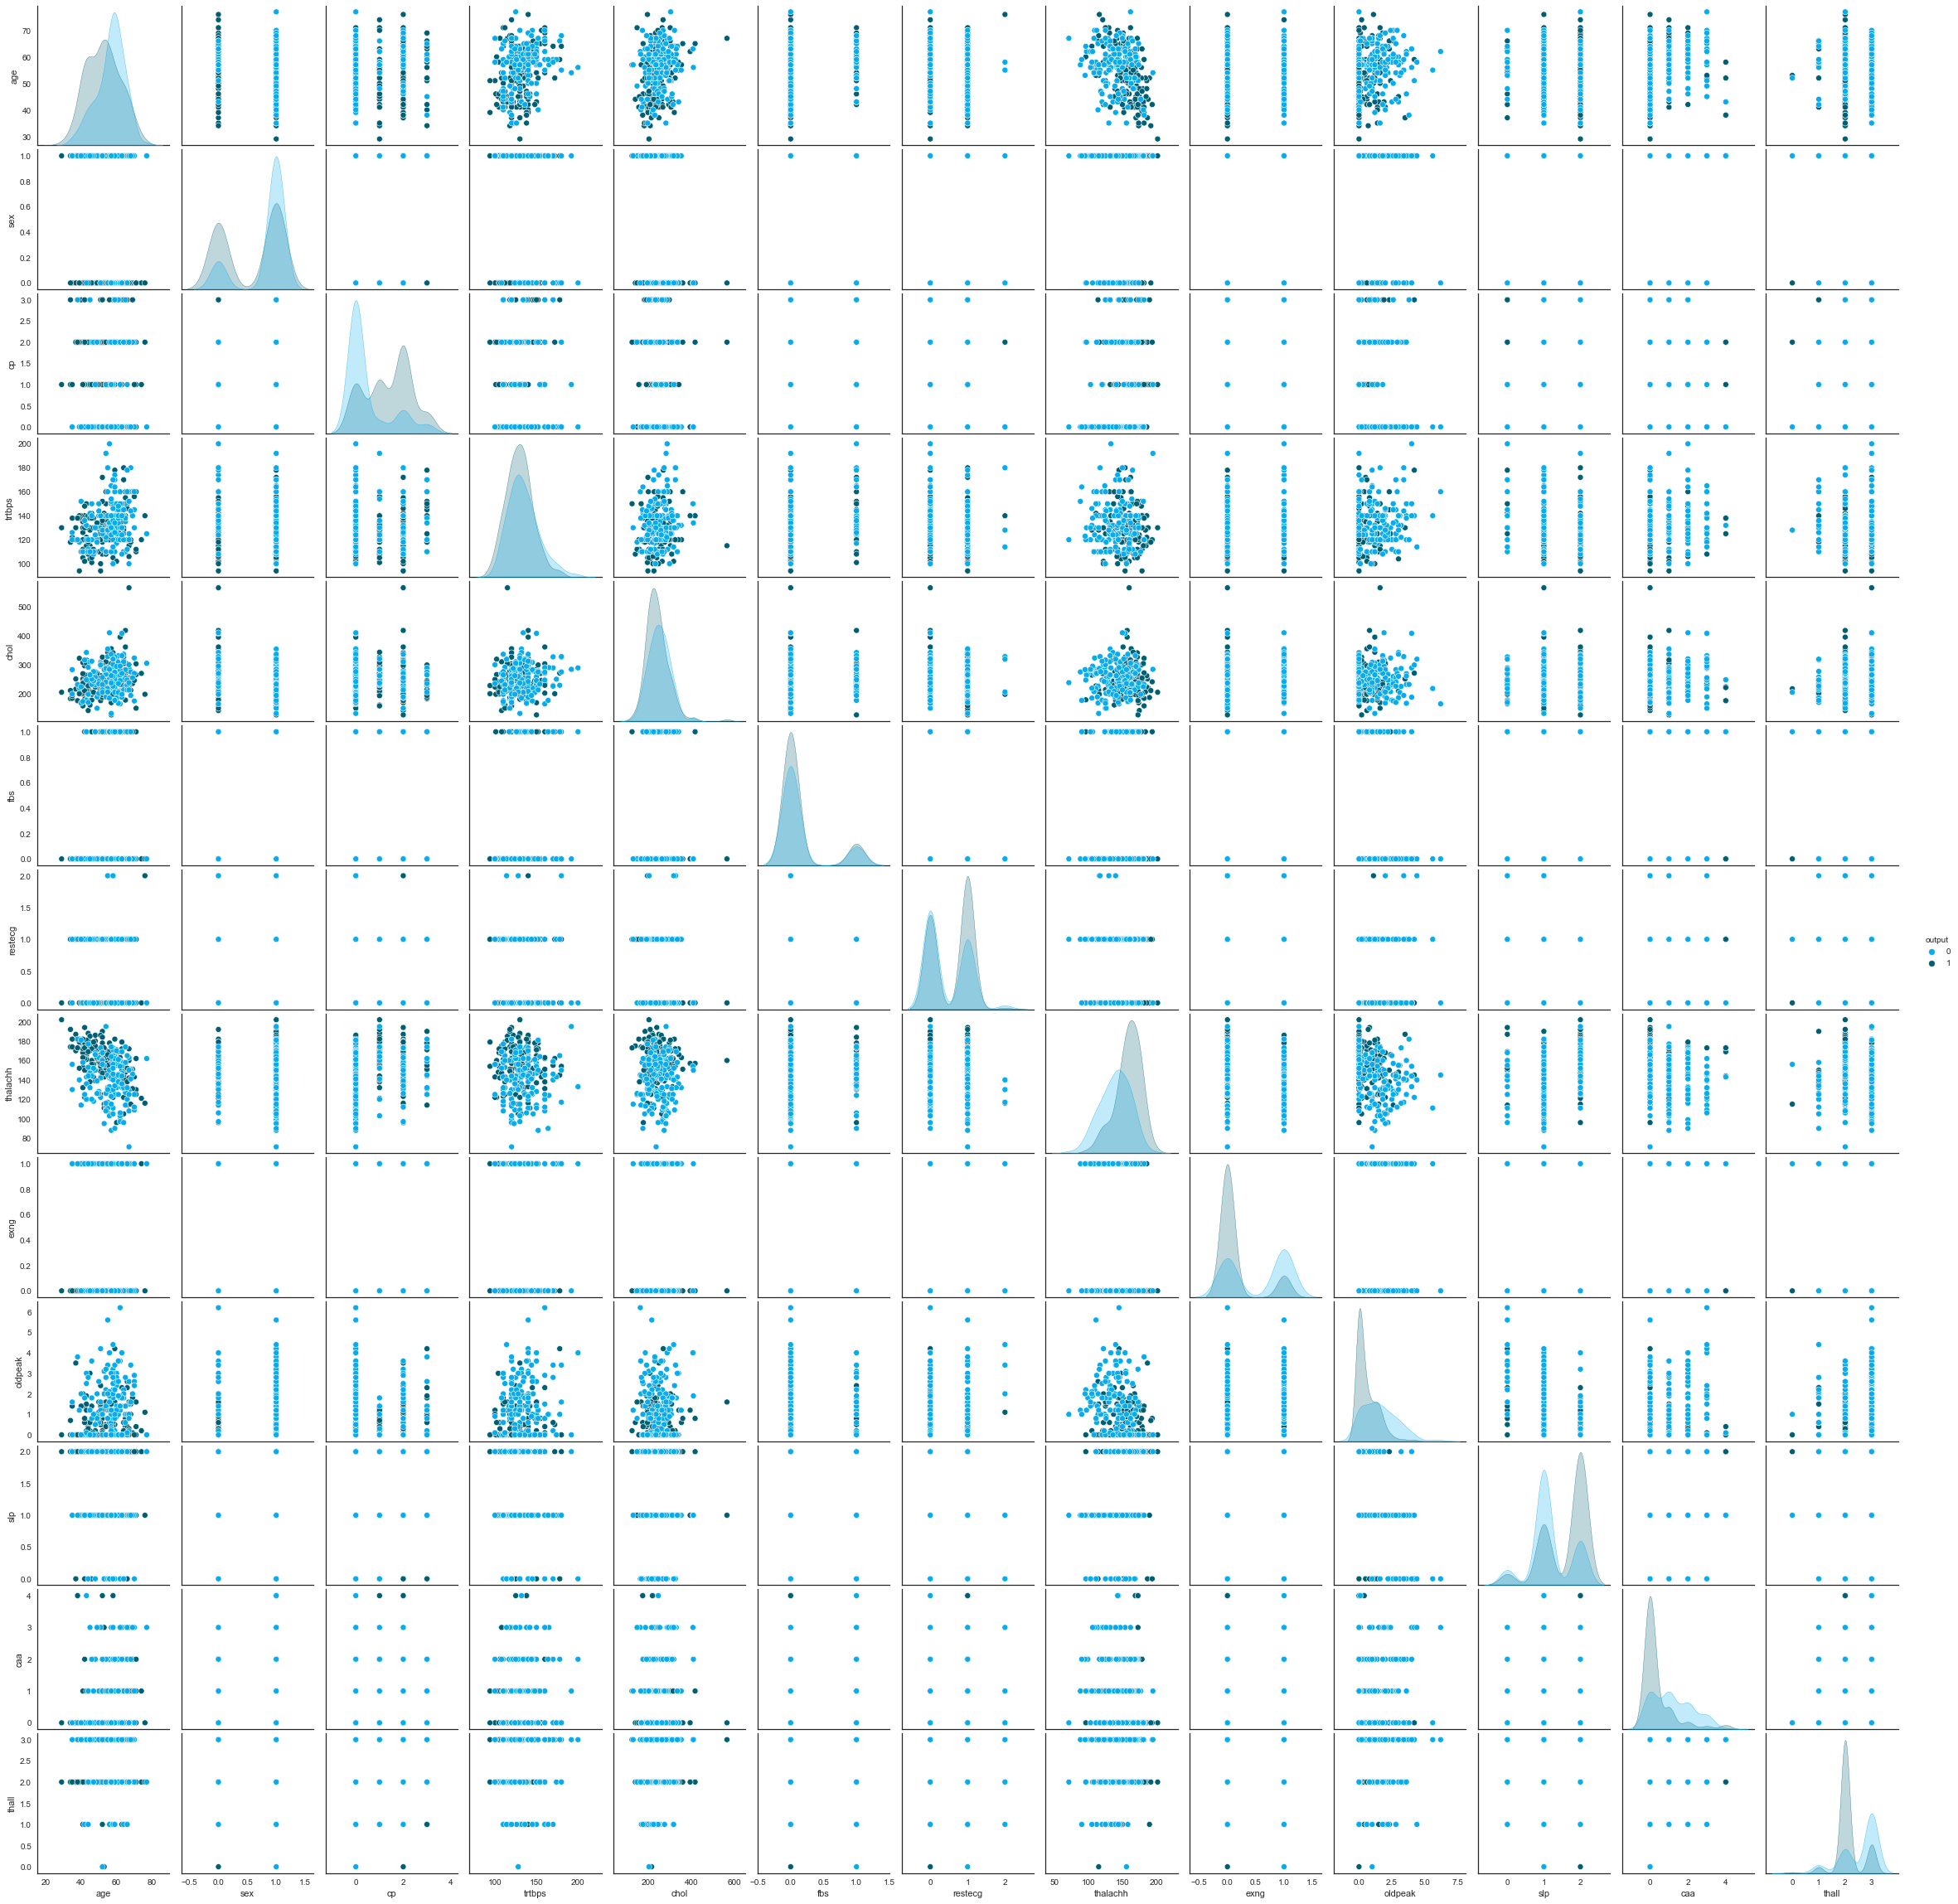

In [12]:
# pairplot on all variables wrt output

sns.pairplot(heart_df, hue = 'output', palette = colour_palette[0:2]);

In [13]:
## Train test split on the dataset 

X = heart_df.drop('output', 1)
y = heart_df[['output']]

## Random State = 42, seems to be a popular arbitrary number to use for the random state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print('Shape of the training data', X_train.shape, y_train.shape)
print('Shape of the testing data', X_test.shape, y_test.shape)

Shape of the training data (242, 13) (242, 1)
Shape of the testing data (61, 13) (61, 1)


## Applying Models

### K-Nearest Neighbours (KNN) model

#### Using 4 nearest neighbours as default

In [14]:
# Creating the KNN model to use with n equal to 4 (chosen at random by default)
# General rule for default n is to use odd n if no of variables is even and vice versa. 
# There are 13 features (odd) so will use n = 4
knn = KNeighborsClassifier(n_neighbors=4)

# Fitting the knn model with the feature and target data created previously
knn.fit(X_train, np.ravel(y_train))

# getting the predicition values for whole dataset using n=4 
y_pred4 = knn.predict(X_test)

# Check the accuracy score of using n=4 
accuracy_score4 = round(metrics.accuracy_score(y_test, y_pred4), 2)

The accuracy score using n = 4 in this KNN model was {{"{:.2%}".format(accuracy_score4)}}. This is a sub optimal score that I would not be happy with using as the accuracy is an issue if we were to predict the output in a real world scenario using this model.  

For example if this model was used to predict a patients likelihood of a heart attack and the model predicted a 'low chance of heart attack' then we would not feel comfortable with this assessment and if used in the real world as the advice given to the patient may be inaccurate and possibly fatal in some cases

In [15]:
# testing out prediction using a random existing record from the dataset. 
# Using the first row in our dataset in the knn model it was able to predict the same outcome as in the original dataset. 


lastrow_predict = knn.predict(np.array(X_test.head(1)))

Using a random record from our test dataset we can see the model predicted this correctly. We can see that the last row in the test dataset the output was {{y_test['output'].head(1).to_string(index=False)}} and the model predicted the outcome of {{lastrow_predict[0]}}.

#### Finding the best value of K

In [16]:
k_range = range(3, 25)

accuracy_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, np.ravel(y_train))
    y_pred = knn.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

In [17]:
## Creating model with k of highest accuracy

knn = KNeighborsClassifier(n_neighbors=accuracy_scores.index(max(accuracy_scores))+1)
knn.fit(X_train, np.ravel(y_train))
y_pred = knn.predict(X_test)


#### Accuracy scores plot

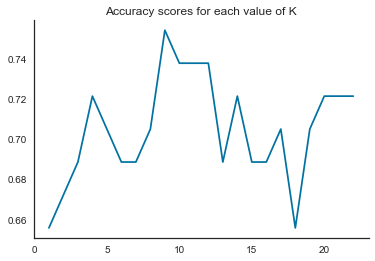

In [18]:
#fig, ax = plt.subplots()
sns.set_style("white")
#sns.set(rc={'figure.figsize':(20, 10)})
sns.lineplot(x=range(1, 23), y=accuracy_scores).set(title="Accuracy scores for each value of K")

sns.despine(top=True, right=True);

Based on the chart above it is easy to see that initally the accuracy starts improving before it dips slightly, as the k increases the accuracy improves by some margin and after it reaches its best accuracy it then starts to tail off and get worse. The best accuracy in general is when we have a lower number of neighbours but we dont want to use these lower numbers as it means our model will be overfitting the data and will not perform well when introducing new datapoints.  

The best K to use for the model would be {{accuracy_scores.index(max(accuracy_scores))+1}} with an accuracy score of {{"{:.2%}".format(max(accuracy_scores))}}

### Logistic Regression

#### Setting up the model

In [19]:

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)
logreg_accuracy = metrics.accuracy_score(y_test, y_pred_logreg)

lastrow_predict_logreg = logreg.predict(np.array(X_test.head(1)))

Using the LogisticRegression model we can see the accuracy of the model dramatically improves to {{"{:.2%}".format(logreg_accuracy)}}. This is an improvement compared to the KNN model however it still isn't optimal. Again this is highly likely due to the relatively small dataset which makes it harder for these models to train and learn to improve the accuracy of its predictions.  

Again using the first row in the test dataset the LogisticRegression model predicts an outcome of {{lastrow_predict_logreg[0]}}. So the improved accuracy still leads to the same classiciation as the KNN model but with a higher accuracy.

### Decision Tree

#### Setting up the model

In [20]:
DecisionTree = DecisionTreeClassifier()

DecisionTree.fit(X_train, y_train)

y_pred_DT = DecisionTree.predict(X_test)
DT_accuracy = metrics.accuracy_score(y_test, y_pred_DT)
lastrow_predict_DT = DecisionTree.predict(np.array(X_test.head(1)))



Using the DecisionTreeClassifer we can see the accuracy of the model is {{"{:.2%}".format(DT_accuracy)}} which is an improvement on the KNN model but still less accurate than the Logistic Regression model. It predicted an outcome of {{lastrow_predict_DT[0]}} which is the same as the other models.  

The next section will evaluate the models to see how well they perform on the whole test set as opposed to one record from the dataset. 

## Evaluating Models

### KNN

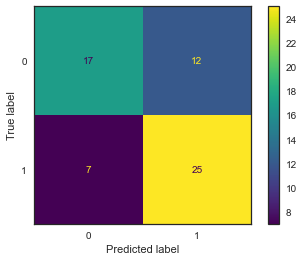

In [21]:
## Running a confustion matrix on the knn model. 

metrics.plot_confusion_matrix(knn, X_test, y_test);

CM = metrics.confusion_matrix(y_test, y_pred)

From the {{X_test.shape[0]}} entries in the dataset, {{CM[0,0]}} were correctly predicted by the knn model to be a Heart Attack whilst {{CM[1,1]}} entries were correctly predicted to not be a heart attack.  
The model had {{CM[0,1] + CM[1,0]}} entries with false positives/negatives.

### Logistic Regression

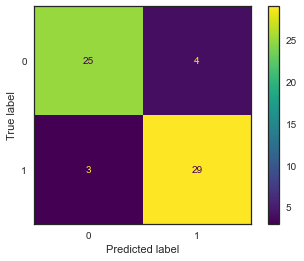

In [22]:
metrics.plot_confusion_matrix(logreg, X_test, y_test)
CM_logreg = metrics.confusion_matrix(y_test, y_pred_logreg)


In the Logistic Regression model as expected we can see a higher number of correct predictions for both outcomes. {{CM_logreg[0,0]}} entries were correctly predicted for a heart attack outcome and {{CM_logreg[0,0]}} for outcome for no heart attack. There were fewer false positives/negatives at {{CM_logreg[0,1] + CM_logreg[1,0]}}.

### Decision Tree

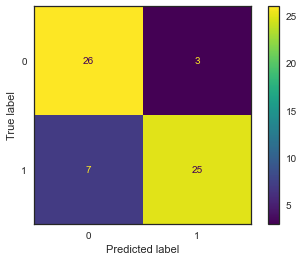

In [23]:
metrics.plot_confusion_matrix(DecisionTree, X_test, y_test)
CM_DT = metrics.confusion_matrix(y_test, y_pred_DT)

In the Decision Tree model as expected we can see a higher number of correct predictions for both outcomes than the KNN model but slightly less than the Logistic Regression model. {{CM_DT[0,0]}} entries were correctly predicted for a heart attack outcome and {{CM_DT[0,0]}} for outcome for no heart attack. There were fewer false positives/negatives at {{CM_DT[0,1] + CM_DT[1,0]}} than the KNN model but only marginally more than the Logistic Regression model.

## Optimizing models using Feature Scaling

>Feature scaling is a method used to normalize the range of independent variables or features of data.  

The reason I am applying these feature scaling techniques is due to the fact that each feature of the dataset have a broad range of values and by normalising these we can hopefully build a more robust and accurate model.  

Looking at the summary statistics once again you will see how each feature is on a different scale to each other: 

{{heart_df.describe()}}  

By normalising this it will help our models given that they are all distance based models.  

>Standardisation is generally preferred over normalisation in most machine learning context as it is especially important when comparing the similarities between features based on certain distance measures.  


So I will be using the StandardScaler to apply on the features. 

In [30]:
Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

After using the StandardScalar we can see now the same values in our test dataframe do not have a broad range of values and all the features look like their values have been standardised which is optimal for the distance based models. 

{{pd.DataFrame(X_test).describe()}}  

I will now rerun each of the models using the same parameters to determine if accuracy is much more improved. 

### KNN model (after Feature Scaling)

In [34]:
# Creating the KNN model after feature scaling using k = 9 as this was the optimum previously
knn = KNeighborsClassifier(n_neighbors = 9)

# Fitting the knn model with the feature and target data created previously
knn.fit(X_train, np.ravel(y_train))

# getting the predicition values for whole dataset using n=4 
y_pred9 = knn.predict(X_test)

# Check the accuracy score of using n=4 
accuracy_score9 = round(metrics.accuracy_score(y_test, y_pred9), 2)

The accuracy score using n = 9 in this KNN model was {{"{:.2%}".format(accuracy_score9)}}. We can clearly see here how the KNN model's accuracy has greatly improved from 67% to 90%. Showing how important it is to feature scale the dataset if each features values vary alot. 

#### Accuracy scores plot

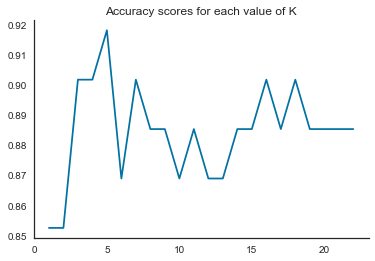

In [36]:
## Checking accuracy scores for all values of K

k_range = range(3, 25)

accuracy_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, np.ravel(y_train))
    y_pred = knn.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    
#fig, ax = plt.subplots()
sns.set_style("white")
#sns.set(rc={'figure.figsize':(20, 10)})
sns.lineplot(x=range(1, 23), y=accuracy_scores).set(title="Accuracy scores for each value of K")

sns.despine(top=True, right=True);

Again plotting the accuracy scores for every value of k shows here that the initial optimal value of K we found earlier is not as accurate as it could be. Instead here the best value of k to use would be {{accuracy_scores.index(max(accuracy_scores))+1}} with an accuracy score of {{"{:.2%}".format(max(accuracy_scores))}}. In the KNN model, as mentioned previously, the best accuracy in general is when we have a lower number of neighbours but we dont want to use these lower numbers as it means our model will be overfitting the data and will not perform well when introducing new datapoints.   

### Logistic Regression (after Feature Scaling)

In [38]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)
logreg_accuracy = metrics.accuracy_score(y_test, y_pred_logreg)

Our logistic regression model accuracy has actually decreased after feature scaling to an accuracy score of {{"{:.2%}".format(logreg_accuracy)}} which is less accurate than before feature scaling. 

Some sources have alluded to that fact that LogisticRegression may not need this scaling applied[<sup>5</sup>](#fn5).  

However another source has suggested that feature scaling when the dataset has a mix of categorical and ordinal features then it can give results that arent accurate which is highly likely in this dataset given that is the case.[<sup>6</sup>](#fn6)  

Tree based models do not need feature scaling to be applied so I will not be performing another Decision Tree model after feature scaling.[<sup>7</sup>](#fn7)

## References

<span id="fn1">[1: https://www.everydayhealth.com/heart-health/cholesterol-and-heart-attack-risk/](https://www.everydayhealth.com/heart-health/cholesterol-and-heart-attack-risk/) </span>  
<span id="fn2">[2: https://www.healthline.com/health-news/cholesterol-and-heart-attacks](https://www.healthline.com/health-news/cholesterol-and-heart-attacks) </span>  
<span id="fn3">[3: https://www.heart.org/en/health-topics/high-blood-pressure/health-threats-from-high-blood-pressure](https://www.heart.org/en/health-topics/high-blood-pressure/health-threats-from-high-blood-pressure)</span>  
<span id="fn4">[4: https://www.nhs.uk/conditions/heart-attack/causes/](https://www.nhs.uk/conditions/heart-attack/causes/)</span>  
<span id="fn5">[5: https://stats.stackexchange.com/questions/48360/is-standardization-needed-before-fitting-logistic-regression](https://stats.stackexchange.com/questions/48360/is-standardization-needed-before-fitting-logistic-regression) </span>  
<span id="fn6">[6: https://stackoverflow.com/questions/26668316/effect-of-feature-scaling-on-accuracy](https://stackoverflow.com/questions/26668316/effect-of-feature-scaling-on-accuracy)</span>  
<span id="fn7">[7: https://towardsdatascience.com/what-is-feature-scaling-why-is-it-important-in-machine-learning-2854ae877048](https://towardsdatascience.com/what-is-feature-scaling-why-is-it-important-in-machine-learning-2854ae877048)</span>
          